In [1]:
import pandas as pd

#get pandas and sql to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql

from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import matplotlib.pyplot as plt

In [2]:
params = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'user': 'agar',
    'dbname': 'votes',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**params)

In [3]:
sql_query = """
select *, 
case 
	when party = 'republican'
		then 0
	when party = 'democrat'
		then 1
	end as party_id 

from	
(
select year, party, 
case 
	when district<10 
		then concat(state_po, '-0', district)
	when district>9	
		then concat(state_po, '-', district)
		end as district_id
from
(
select * from
(select year, state_po, district, party, max_candidatevotes, row_number() OVER (partition by year, state_po, district ORDER BY max_candidatevotes desc) as row_num from

(select year, state_po, district, party, max(cast((REPLACE(candidatevotes, ',', '')) as int)) as max_candidatevotes
from "H_of_Rep"
group by year, state_po, district, party
order by year, state_po, district) as winners) as winners_rank
where row_num = 1
 ) as winners_only
 ) as winners_years
 
 order by district_id, year
;
"""

In [4]:
df = pd.read_sql_query(sql_query, connection, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)

In [5]:
df

,year,party,district_id,party_id
0,1976,republican,AK-00,0.0
1,1978,republican,AK-00,0.0
2,1980,republican,AK-00,0.0
3,1982,republican,AK-00,0.0
4,1984,republican,AK-00,0.0
...,...,...,...,...
9565,2010,republican,WY-00,0.0
9566,2012,republican,WY-00,0.0
9567,2014,republican,WY-00,0.0
9568,2016,republican,WY-00,0.0


In [12]:
"""
from sqlalchemy import create_engine
connection_string = f'postgres://agar:{params["host"]}@{params["host"]}:{params["port"]}/votes'
engine = create_engine(connection_string, pool_pre_ping=True)
df.iloc[:0].to_sql("Winners+", engine, index=False)
df.iloc[:].to_sql("Winners+", engine, index=False, if_exists = 'append', chunksize = 1000)
"""

In [9]:
df.columns

Index(['year', 'party', 'district_id', 'party_id'], dtype='object')

In [7]:
df[["PREV_YEAR", "PREV_PARTY_ID"]] = (df.groupby(["district_id"])['year', 'party_id']
                                                       .transform(lambda grp: grp.shift(1)))

In [11]:
df.head()

,year,party,district_id,party_id,PREV_YEAR,PREV_PARTY_ID,party change
1,1978,republican,AK-00,0.0,1976.0,0.0,0.0
2,1980,republican,AK-00,0.0,1978.0,0.0,0.0
3,1982,republican,AK-00,0.0,1980.0,0.0,0.0
4,1984,republican,AK-00,0.0,1982.0,0.0,0.0
5,1986,republican,AK-00,0.0,1984.0,0.0,0.0


In [9]:
df = df.dropna(subset=["PREV_YEAR"], axis=0)

In [10]:
df["party change"] = (df["party_id"]-df["PREV_PARTY_ID"])

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.groupby("party change").size()

party change
-1.0     418
 0.0    8194
 1.0     359
dtype: int64

In [13]:

from sqlalchemy import create_engine
connection_string = f'postgres://agar:{params["host"]}@{params["host"]}:{params["port"]}/votes'
engine = create_engine(connection_string, pool_pre_ping=True)
df.iloc[:0].to_sql("Party_change_multiclass", engine, index=False)
df.iloc[:].to_sql("Party_change_multiclass", engine, index=False, if_exists = 'append', chunksize = 1000)


In [30]:
df["party_change_simple"] = (df["party_id"]-df["PREV_PARTY_ID"]).abs()

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
mask = (df["year"] == 2014) 
        

In [44]:
df[mask].head()

,year,party,district_id,party_id,PREV_YEAR,PREV_PARTY_ID,party change,party_change_simple
19,2014,republican,AK-00,0.0,2012.0,0.0,0.0,0.0
41,2014,republican,AL-01,0.0,2012.0,0.0,0.0,0.0
63,2014,republican,AL-02,0.0,2012.0,0.0,0.0,0.0
85,2014,republican,AL-03,0.0,2012.0,0.0,0.0,0.0
107,2014,republican,AL-04,0.0,2012.0,0.0,0.0,0.0


In [45]:
df[mask].groupby("party_change_simple").size()

party_change_simple
0.0    411
1.0     20
dtype: int64

In [46]:
# 2014 party flips - 5%
20/411

0.04866180048661801

In [48]:
mask2 = (df["year"] == 2016) 
df[mask2].groupby("party_change_simple").size()

party_change_simple
0.0    420
1.0     12
dtype: int64

In [49]:
# 2016 party flips - 3%
12/411

0.029197080291970802

In [50]:
mask3 = (df["year"] == 2018) 
df[mask3].groupby("party_change_simple").size()

party_change_simple
0.0    378
1.0     52
dtype: int64

In [51]:
# 2018 party flips - 13%
52/378

0.13756613756613756

In [34]:
df.groupby("party_change_simple").size()

party_change_simple
0.0    8194
1.0     777
dtype: int64

In [35]:
777/8194
# 9% of districts from 1976 to now have flipped parties

0.09482548206004393

In [40]:
df.groupby("year").size()

year
1978    435
1980    435
1982    416
1984    435
1986    435
1988    435
1990    435
1992    415
1994    435
1996    435
1998    435
2000    435
2002    423
2004    435
2006    435
2008    435
2010    435
2012    423
2014    435
2016    435
2018    435
dtype: int64

In [60]:
df.groupby(["year"])["party_change_simple"].agg('sum'))

#df.groupby(['Name', 'Fruit'])['Number'].agg('sum')

SyntaxError: invalid syntax (<ipython-input-60-5d622cea4339>, line 1)

In [62]:
flips_yearly_df = df.groupby('year')['party_change_simple'].sum()

In [67]:
flips_yearly_df

year
1978    35.0
1980    40.0
1982    65.0
1984    25.0
1986    27.0
1988    14.0
1990    21.0
1992    76.0
1994    63.0
1996    43.0
1998    21.0
2000    16.0
2002    41.0
2004    17.0
2006    31.0
2008    30.0
2010    65.0
2012    63.0
2014    20.0
2016    12.0
2018    52.0
Name: party_change_simple, dtype: float64

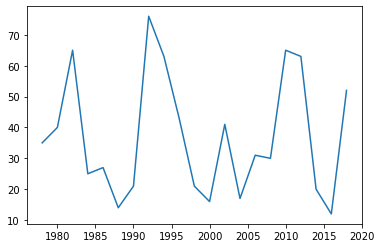

In [66]:
# number of districts that flip yearly
plt.plot(flips_yearly_df)

In [68]:
simple_df = df[["year", "district_id", "party_change_simple"]]

In [69]:
simple_df.head()

,year,district_id,party_change_simple
1,1978,AK-00,0.0
2,1980,AK-00,0.0
3,1982,AK-00,0.0
4,1984,AK-00,0.0
5,1986,AK-00,0.0


In [70]:
from sqlalchemy import create_engine
connection_string = f'postgres://agar:{params["host"]}@{params["host"]}:{params["port"]}/votes'
engine = create_engine(connection_string, pool_pre_ping=True)

In [71]:
simple_df.iloc[:0].to_sql("Flips", engine, index=False)

In [72]:
simple_df.iloc[:].to_sql("Flips", engine, index=False, if_exists = 'append', chunksize = 1000)